In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [32]:
ab = '../talon/human_talon_abundance.tsv'
filt_ab = 'cerberus_filtered_abundance.tsv'
c_annot = 'cerberus_annot.h5'
ver = 'v40_cerberus'
complete_novs = ['Known', 'NIC', 'NNC', 'ISM_rescue']

## PolyA gene transcript detection

What fraction of polyA genes from the annotation do we detect with at least 1 known isoform >= 1 TPM in any library?

In [11]:
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df,
               how='iso',
               nov=['Known'],
               min_tpm=1,
               gene_subset='polya')

# merge with gene id
gene_df = pd.read_csv(filt_ab, sep='\t')
gene_df = gene_df[['annot_gene_id', 'annot_transcript_id']]
df = df.merge(gene_df, how='left', left_index=True, right_on='annot_transcript_id')

gene_df, _, _ = get_gtf_info(how='gene', ver=ver)

polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
polya_genes = gene_df.loc[gene_df.biotype_category.isin(polya_biotypes), 'gid'].tolist()
n_polya = len(polya_genes)
n_det_polya = len(df.annot_gene_id.unique().tolist())

print('Detected {} / {} ({:.2f}%) annotated polyA genes w/ at least 1 known transcript >= 1 TPM'.format(n_det_polya, n_polya, (n_det_polya/n_polya)*100))

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1297: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1298: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 132274
Detected 26446 / 52274 (50.59%) annotated polyA genes w/ at least 1 known transcript >= 1 TPM


## TF gene transcript detection

What fraction of TF genes from the annotation do we detect with at least 1 known isoform >= 1 TPM in any library?

In [12]:
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='tf')

# merge with gene id
gene_df = pd.read_csv(filt_ab, sep='\t')
gene_df = gene_df[['annot_gene_id', 'annot_transcript_id']]
df = df.merge(gene_df, how='left', left_index=True, right_on='annot_transcript_id')

gene_df, _, _ = get_gtf_info(how='gene', subset='tf', ver=ver)

n_tf = len(gene_df.index)
n_det_tf = len(df.annot_gene_id.unique().tolist())

print('Detected {} / {} ({:.2f}%) annotated TF genes w/ at least 1 known transcript >= 1 TPM'.format(n_det_tf, n_tf, (n_det_tf/n_tf)*100))

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for tf genes
Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 9102
Detected 1326 / 1419 (93.45%) annotated TF genes w/ at least 1 known transcript >= 1 TPM


Which TFs have the most isoforms?

In [7]:
df = pd.read_csv(filt_ab, sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='tf',
                       groupby='all', 
                       nov=complete_novs)
gene_df, _, _ = get_gtf_info(how='gene', ver=ver, add_stable_gid=True)

df.reset_index(inplace=True)
df['gid_stable'] = cerberus.get_stable_gid(df, 'annot_gene_id')
df.set_index('annot_gene_id')
      
df = df.merge(gene_df[['gid_stable', 'gname']], 
              how='left', 
              on='gid_stable')
df = df.sort_values(by='all', ascending=False)
df.head(10)

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for tf genes
Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 13122


,annot_gene_id,all,gid_stable,gname
87,ENSG00000081189.15,74,ENSG00000081189,MEF2C
5,ENSG00000005801.17,71,ENSG00000005801,ZNF195
68,ENSG00000071564.14,67,ENSG00000071564,TCF3
120,ENSG00000095794.19,66,ENSG00000095794,CREM
44,ENSG00000062194.15,64,ENSG00000062194,GPBP1
843,ENSG00000175387.15,64,ENSG00000175387,SMAD2
62,ENSG00000068305.17,59,ENSG00000068305,MEF2A
302,ENSG00000120837.7,57,ENSG00000120837,NFYB
404,ENSG00000130844.17,57,ENSG00000130844,ZNF331
100,ENSG00000085274.15,56,ENSG00000085274,MYNN


Which TF has the most isoforms expressed in a single sample? 

In [9]:
df = pd.read_csv(filt_ab, sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='tf',
                       groupby='sample', 
                       nov=complete_novs)
df['max_sample'] = df.max(1)
df = df['max_sample'].to_frame()

gene_df, _, _ = get_gtf_info(how='gene', ver=ver, add_stable_gid=True)
df.reset_index(inplace=True)
df['gid_stable'] = cerberus.get_stable_gid(df, 'annot_gene_id')
df.set_index('annot_gene_id')
df = df.merge(gene_df[['gid_stable', 'gname']], 
              how='left', 
              on='gid_stable')

df = df.sort_values(by='max_sample', ascending=False)
df.head(10)

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for tf genes
Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 13122
Found 50 total samples


,annot_gene_id,max_sample,gid_stable,gname
250,ENSG00000115415.18,44.0,ENSG00000115415,STAT1
120,ENSG00000095794.19,42.0,ENSG00000095794,CREM
87,ENSG00000081189.15,41.0,ENSG00000081189,MEF2C
62,ENSG00000068305.17,41.0,ENSG00000068305,MEF2A
44,ENSG00000062194.15,41.0,ENSG00000062194,GPBP1
471,ENSG00000137504.13,38.0,ENSG00000137504,CREBZF
728,ENSG00000168610.14,36.0,ENSG00000168610,STAT3
5,ENSG00000005801.17,36.0,ENSG00000005801,ZNF195
364,ENSG00000126561.16,35.0,ENSG00000126561,STAT5A
101,ENSG00000085276.17,34.0,ENSG00000085276,MECOM


## Protein coding gene transcript detection

What fraction of protein-coding genes do we detect with at least 1 known isoform >= 1 TPM in any library?

In [13]:
df = pd.read_csv(filt_ab, sep='\t')
# no gene subset here so we can look at all other genes
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1)

# merge with gene id
gene_df = pd.read_csv(filt_ab, sep='\t')
gene_df = gene_df[['annot_gene_id', 'annot_transcript_id']]
df = df.merge(gene_df, how='left', left_index=True, right_on='annot_transcript_id')

gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene', ver=ver, add_stable_gid=True)
df['gid_stable'] = cerberus.get_stable_gid(df, 'annot_gene_id')
df = df.merge(gene_df, how='left', on='gid_stable')

temp = df[['gid', 'biotype_category']].drop_duplicates().groupby('biotype_category').count()
temp.reset_index(inplace=True)
temp.rename({'gid': 'detected_counts'}, axis=1, inplace=True)

temp = temp.merge(b_cat_counts, on='biotype_category', how='outer')
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts
temp.sort_values(by='prop_detected', ascending=False, inplace=True)
temp

Calculating iso TPM values
Subsetting for novelty categories ['Known']


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 135125


,biotype_category,detected_counts,gencode_counts,prop_detected
3,protein_coding,17321,19988,0.866570
0,lncRNA,5298,17748,0.298513
2,other,2197,7391,0.297253
4,pseudogene,3678,14538,0.252992
1,miRNA,466,1879,0.248004


## What fraction of protein coding gene transcripts do we detect?

Of the transcripts associated with protein coding genes GENCODE, how many do we detect >=1 TPM?

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

ab = '../talon/human_talon_abundance.tsv'
filt_ab = 'cerberus_filtered_abundance.tsv'
c_annot = 'cerberus_annot.h5'
ver = 'v40_cerberus'
complete_novs = ['Known', 'NIC', 'NNC', 'ISM_rescue']

In [25]:
# transcript level
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df,
                   how='ic',
                   # nov=['Known'], # don't need to limit b/c ic will tell us
                   min_tpm=1,
                   gene_subset='polya')
t_df, b_counts, b_cat_counts = get_gtf_info(how='ic', ver=ver, subset='polya')
df = df.merge(t_df, how='inner', left_index=True, right_on='ic')
temp = df[['ic', 'biotype_category']].groupby('biotype_category', dropna=False).count()
temp.reset_index(inplace=True)
temp.rename({'ic': 'detected_counts'}, axis=1, inplace=True)

temp = temp.merge(b_cat_counts, on='biotype_category', how='outer')
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts
temp.sort_values(by='prop_detected', ascending=False, inplace=True)
temp

Calculating ic TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1373: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1372: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # ics detected: 149743
# ics >= 1 tpm: 135923
Applying gene type and novelty subset
Number of ics reported: 132337


,biotype_category,detected_counts,gencode_counts,prop_detected
1,protein_coding,68694,164642,0.417233
2,pseudogene,4343,18856,0.230325
0,lncRNA,8266,50082,0.165049


In [27]:
temp = temp[['detected_counts', 'gencode_counts']]
temp = temp.sum(axis=0)
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts

In [28]:
temp

detected_counts     81303.000000
gencode_counts     233580.000000
prop_detected           0.348073
dtype: float64

## Characteristics of detected known, polyA gene associated transcripts

## Number of cell types or tissues that each known transcript from polyA genes is expressed >= 1 TPM

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 132274
Found 50 total samples


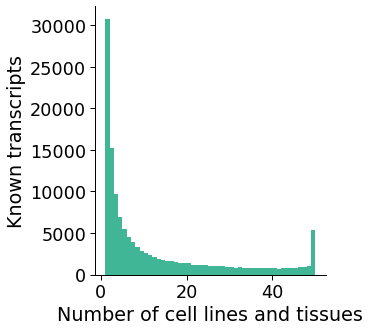

In [5]:
df = pd.read_csv(filt_ab, sep='\t')
df = plot_biosamp_det(df,
                      how='iso',
                      min_tpm=1,
                      gene_subset='polya',
                      sample=None,
                      groupby='sample',
                      nov='Known',
                      opref='figures/human')

In [6]:
specific_thresh = 8
ubiq_thresh = 30

n_iso = len(df.index)
n_specific = len(df.loc[df.n_samples <= specific_thresh].index)
n_ubiq = len(df.loc[df.n_samples >= ubiq_thresh].index)

print('{} / {} ({:.1f}%) transcripts are expressed in <= {} samples'.format(n_specific, n_iso, (n_specific/n_iso)*100, specific_thresh))
print('{} / {} ({:.1f}%) transcripts are expressed in >= {} samples'.format(n_ubiq, n_iso, (n_ubiq/n_iso)*100, ubiq_thresh))

79616 / 132274 (60.2%) transcripts are expressed in <= 8 samples
20673 / 132274 (15.6%) transcripts are expressed in >= 30 samples


## Length of transcripts from polyA genes detected >= 1 TPM

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 132274


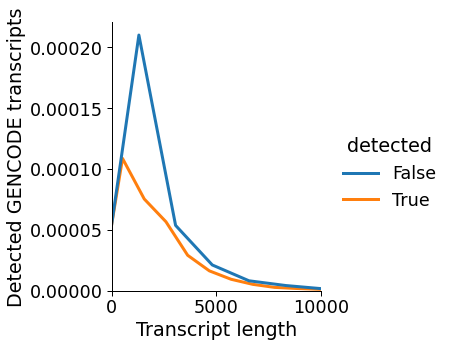

In [13]:
df = pd.read_csv(filt_ab, sep='\t')
df = plot_det_len_kde(df, 
                      how='iso', 
                      subset='polya',
                      min_tpm=1,
                      xlim=10000,
                      opref='figures/',
                      ver=ver)

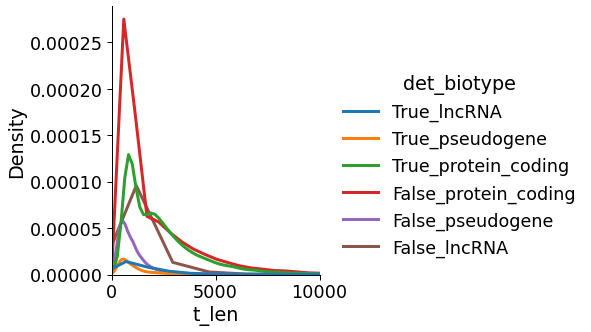

In [14]:
df['det_biotype'] = df.detected.astype('str')+'_'+df.biotype_category
ax = sns.displot(data=df, x='t_len', kind='kde',
                     linewidth=3, hue='det_biotype', common_norm=True)
ax.set(xlim=(0,10000))

What is the longest detected transcript with more than one exon?

In [15]:
t_df = pd.read_csv(filt_ab, sep='\t')
t_df = t_df[['annot_transcript_id', 'n_exons']]
df = df.merge(t_df, how='left', on='annot_transcript_id')
n = df.loc[(df.detected == True)&(df.n_exons > 1), 't_len'].max()
print(n)
df.loc[df.t_len == n]

37978.0


,annot_transcript_id,tid,t_len,gid,gname,biotype,biotype_category,tf,detected,det_biotype,n_exons
125816,"ENSG00000224086[1,1,2]","ENSG00000224086[1,1,2]",37978.0,ENSG00000224086.6,PPM1F-AS1,lncRNA,lncRNA,False,True,True_lncRNA,2.0


## Variance in TPM levels >= 1 TPM for known transcripts detected >= 1 TPM

In [29]:
# df = pd.read_csv(filt_ab, sep='\t')
# df = get_tpm_table(df,
#                    how='iso',
#                    nov=['Known'],
#                    min_tpm=1,
#                    gene_subset='polya')

## How many known polyA intron chains do we detect?

In [31]:
df = pd.read_csv(filt_ab, sep='\t')
df, _ = get_tpm_table(df,
                   how='ic',
                   min_tpm=1,
                   gene_subset='polya')
# merge with transcript len
t_df, b_counts, c_counts = get_gtf_info(how='ic', ver='v40_cerberus')
df = df.merge(t_df, how='inner', left_index=True, right_on='ic')
polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
n_det_polya = len(df.index)
n_known_polya = c_counts.loc[c_counts.biotype_category.isin(polya_biotypes), 'gencode_counts'].sum()
print('Detected {} / {} ({:.2f}%) annotated transcripts from polyA genes >= 1 TPM'.format(n_det_polya, n_known_polya, (n_det_polya/n_known_polya)*100))

Calculating ic TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # ics detected: 149743
# ics >= 1 tpm: 135923
Applying gene type and novelty subset
Number of ics reported: 132337
Detected 81303 / 233580 (34.81%) annotated transcripts from polyA genes >= 1 TPM


## How many complete isoforms do we detect?

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164
  transcript_novelty  counts
0         ISM_rescue   26508
1              Known  132274
2                NIC   46434
3                NNC   13948
Number of complete isoforms: 219164


<Figure size 288x432 with 0 Axes>

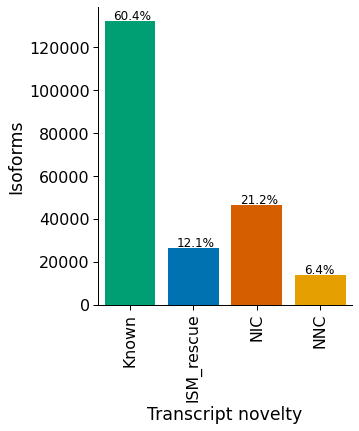

<Figure size 432x288 with 0 Axes>

In [33]:
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=complete_novs,
                   min_tpm=1,
                   gene_subset='polya')

df = pd.read_csv(filt_ab, sep='\t')
plot_transcript_novelty(df,
                        oprefix='figures/complete_det',
                        whitelist=tids,
                        novs=complete_novs,
                        save_type='png')

In [3]:
n = 26508+46434+13948
print('Number of novel transcripts: {}'.format(n))

Number of novel transcripts: 86890


## How many exons are in each complete, detected model, split by novelty?

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164


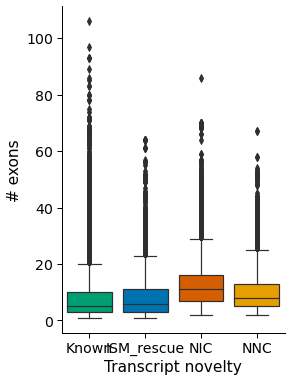

In [4]:
df = pd.read_csv(filt_ab, sep='\t')
plot_exons_per_iso(df,
                   nov=complete_novs,
                   min_tpm=1,
                   gene_subset='polya',
                   opref='figures/human')

## How many isoforms per gene do we detect per sample?

What is the average and range of complete isoforms per polyA gene that we detect per sample?

In [6]:
df = pd.read_csv(filt_ab, sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample', 
                       nov=complete_novs)

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164
Found 50 total samples


In [7]:
df.idxmax(axis=1)

annot_gene_id
ENSG00000000003.14     h9_panc_progen
ENSG00000000005.5        h9_panc_beta
ENSG00000000419.12    h9_neural_crest
ENSG00000000457.13    h9_neural_crest
ENSG00000000460.16     h9_panc_progen
                           ...       
ENSG00000285967.1                k562
ENSG00000285972.1             gm12878
ENSG00000285976.1                lung
ENSG00000285988.1               wtc11
ENSG00000285991.1              mcf10a
Length: 26940, dtype: object

In [8]:
print('Average # isoforms / gene / sample: {}'.format(df.mean().mean()))

Average # isoforms / gene / sample: 4.049808370669015


In [9]:
print('Max # isoforms / gene / sample: {}'.format(df.max().max()))

Max # isoforms / gene / sample: 281.0


In [11]:
df.head()

,a673,adipose,adrenal gland,brain,caco2,calu3,colon,gm12878,h1,h1_de,...,ovary,panc1,pc3,pc9,pgp1,pgp1_astro,pgp1_endo,pgp1_excite_neuron,vessels,wtc11
annot_gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.14,11.0,5.0,4.0,7.0,18.0,8.0,16.0,1.0,13.0,14.0,...,10.0,3.0,4.0,7.0,9.0,7.0,8.0,11.0,6.0,15.0
ENSG00000000005.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000000419.12,8.0,2.0,5.0,8.0,11.0,6.0,6.0,10.0,5.0,4.0,...,5.0,6.0,5.0,7.0,6.0,8.0,5.0,6.0,8.0,5.0
ENSG00000000457.13,3.0,1.0,3.0,3.0,4.0,4.0,2.0,3.0,2.0,4.0,...,3.0,2.0,1.0,1.0,1.0,2.0,1.0,NaN,1.0,3.0
ENSG00000000460.16,6.0,NaN,2.0,1.0,4.0,3.0,2.0,8.0,8.0,7.0,...,2.0,3.0,1.0,5.0,4.0,1.0,1.0,2.0,1.0,3.0


In [14]:
temp = df.melt(ignore_index=False)

In [16]:
temp.loc[temp.value == df.max().max()]

,variable,value
annot_gene_id,,
ENSG00000049540.16,h9_chondro,281.0


How does the total # of isoforms we detect / gene compare to the number of annotated isoforms / gene

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

ab = '../talon/human_talon_abundance.tsv'
filt_ab = 'cerberus_filtered_abundance.tsv'
c_annot = 'cerberus_annot.h5'
ver = 'v40_cerberus'
complete_novs = ['Known', 'NIC', 'NNC', 'ISM_rescue']

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1299: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1300: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164
[1.5602256040717162, 367.89551363728026]


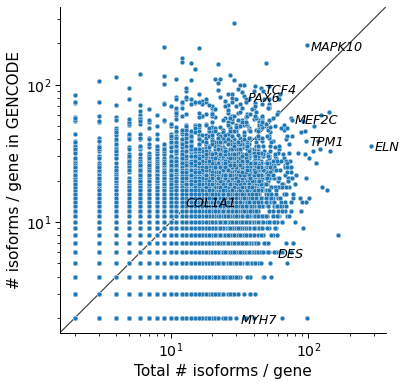

In [2]:
df = pd.read_csv(filt_ab, sep='\t')
genes = ['ELN', 'DES', 'TPM1', 'MEF2C',
         'MYH7', 'MAPK10', 'PAX6', 'TCF4', 'COL1A1']
df = plot_det_vs_gencode_isos(df, 
                         min_tpm=1,
                         gene_subset='polya',
                         nov=complete_novs,
                         label_genes=genes, 
                         ver=ver,
                         opref='figures/human')

In [7]:
df.sort_values(by='n_isos_gencode', ascending=False)

,annot_gene_id,n_isos_det,gid,n_isos_gencode,gname
13641,ENSG00000179818.13,28,ENSG00000179818,278.0,PCBP1-AS1
3557,ENSG00000109339.21,97,ENSG00000109339,192.0,MAPK10
18141,ENSG00000226674.9,8,ENSG00000226674,187.0,TEX41
21448,ENSG00000249859.9,15,ENSG00000249859,183.0,PVT1
4294,ENSG00000115392.11,11,ENSG00000115392,156.0,FANCL
...,...,...,...,...,...
26759,ENSG00000284741.1,2,ENSG00000284741,NaN,NaN
26769,ENSG00000284824.1,1,ENSG00000284824,NaN,NaN
26813,ENSG00000285138.1,1,ENSG00000285138,NaN,NaN
26828,ENSG00000285258.1,1,ENSG00000285258,NaN,NaN


In [4]:
entry = df.sort_values(by='n_isos_gencode', ascending=False).head(1)
print('{} has the most annotated isoforms in GENCODE ({})'.format(entry.gname.values[0], entry.n_isos_gencode.values[0]))

PCBP1-AS1 has the most annotated isoforms in GENCODE (278.0)


In [8]:
genes = ['COL1A1', 'TPM1', 'MAPK10', 'ELN', 'DES', 'PCBP1-AS1']
df.loc[df.gname.isin(genes)]

,annot_gene_id,n_isos_det,gid,n_isos_gencode,gname
651,ENSG00000049540.16,286,ENSG00000049540,35.0,ELN
3488,ENSG00000108821.13,11,ENSG00000108821,13.0,COL1A1
3557,ENSG00000109339.21,97,ENSG00000109339,192.0,MAPK10
7619,ENSG00000140416.20,95,ENSG00000140416,38.0,TPM1
12924,ENSG00000175084.11,55,ENSG00000175084,5.0,DES
13641,ENSG00000179818.13,28,ENSG00000179818,278.0,PCBP1-AS1


In [9]:
df.sort_values(by='n_isos_gencode', ascending=False).head()

,annot_gene_id,n_isos_det,gid,n_isos_gencode,gname
13641,ENSG00000179818.13,28,ENSG00000179818,278.0,PCBP1-AS1
3557,ENSG00000109339.21,97,ENSG00000109339,192.0,MAPK10
18141,ENSG00000226674.9,8,ENSG00000226674,187.0,TEX41
21448,ENSG00000249859.9,15,ENSG00000249859,183.0,PVT1
4294,ENSG00000115392.11,11,ENSG00000115392,156.0,FANCL


In [10]:
df.loc[df.gname == 'COL1A1']

,annot_gene_id,n_isos_det,gid,n_isos_gencode,gname
3488,ENSG00000108821.13,11,ENSG00000108821,13.0,COL1A1


In [11]:
df.loc[df.gname == 'DES']

,annot_gene_id,n_isos_det,gid,n_isos_gencode,gname
12924,ENSG00000175084.11,55,ENSG00000175084,5.0,DES


In [12]:
df['ratio'] = df['n_isos_det'] / df['n_isos_gencode']
df.sort_values(by='ratio', ascending=False)
df = df.sort_values(by='ratio', ascending=True)
df.loc[df.n_isos_det > 15]

,annot_gene_id,n_isos_det,gid,n_isos_gencode,gname,ratio
13641,ENSG00000179818.13,28,ENSG00000179818,278.0,PCBP1-AS1,0.100719
20704,ENSG00000242086.8,21,ENSG00000242086,141.0,MUC20-OT1,0.148936
12591,ENSG00000172965.15,20,ENSG00000172965,108.0,MIR4435-2HG,0.185185
15511,ENSG00000196756.11,22,ENSG00000196756,109.0,SNHG17,0.201835
14575,ENSG00000185359.12,21,ENSG00000185359,101.0,HGS,0.207921
...,...,...,...,...,...,...
26214,ENSG00000277957.1,39,ENSG00000277957,1.0,SENP3-EIF4A1,39.000000
23930,ENSG00000265992.1,63,ENSG00000265992,1.0,ESRG,63.000000
22940,ENSG00000259590.1,97,ENSG00000259590,1.0,LINC02244,97.000000
6064,ENSG00000130723.19,28,ENSG00000130723,NaN,NaN,NaN


How does TPM for a gene in a sample relate to the number of models we see in a sample?

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # genes detected: 599976
# genes >= 1 tpm: 292060
Applying gene type and novelty subset
Averaging over biosample
Found 50 total samples
Number of genes reported: 34027
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164
Found 50 total samples


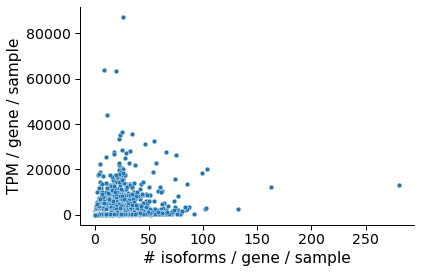

In [26]:
df = pd.read_csv(ab, sep='\t')
filt_df = pd.read_csv(filt_ab, sep='\t')
df = plot_gene_tpm_v_n_isos(df, filt_df, 
                            min_tpm=1, 
                            groupby='sample', 
                            gene_subset='polya', 
                            nov=complete_novs, 
                            opref='figures/human')

In [27]:
df.loc[(df.gname == 'ELN')&(df.biosample == 'h9_chondro')]

,annot_gene_id,biosample,tpm,n_iso,gid,gname
374959,ENSG00000049540.16,h9_chondro,13063.607528,281.0,ENSG00000049540.16,ELN


In [28]:
df.loc[df.tpm > 40000]

,annot_gene_id,biosample,tpm,n_iso,gid,gname
377859,ENSG00000108821.13,h9_chondro,63934.387848,9.0,ENSG00000108821.13,COL1A1
1158632,ENSG00000087086.14,liver,44143.313758,11.0,ENSG00000087086.14,FTL
1167791,ENSG00000163631.16,liver,87160.201515,26.0,ENSG00000163631.16,ALB
1611148,ENSG00000167552.13,pgp1_excite_neuron,63368.654759,20.0,ENSG00000167552.13,TUBA1A


In [29]:
df.loc[df.gname == 'COL1A1'].head()

,annot_gene_id,biosample,tpm,n_iso,gid,gname
3562,ENSG00000108821.13,a673,39.099773,1.0,ENSG00000108821.13,COL1A1
37589,ENSG00000108821.13,adipose,131.496029,1.0,ENSG00000108821.13,COL1A1
71616,ENSG00000108821.13,adrenal gland,110.667449,1.0,ENSG00000108821.13,COL1A1
105643,ENSG00000108821.13,brain,2.852873,1.0,ENSG00000108821.13,COL1A1
139670,ENSG00000108821.13,caco2,7.774921,1.0,ENSG00000108821.13,COL1A1


How does the average number of exons in a gene relate to the number of isoforms we detect for that gene?

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164


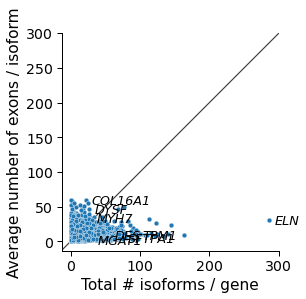

In [30]:
df = pd.read_csv(filt_ab, sep='\t')
g_df = df.copy(deep=True)
g_df = g_df[['n_exons', 'annot_gene_id', 'annot_gene_name']]
g_df = g_df.groupby(['annot_gene_id', 'annot_gene_name']).mean().reset_index()
g_df.rename({'n_exons':'avg_exons'}, axis=1, inplace=True)

# detected isoforms
df = get_isos_per_gene(df,
                   min_tpm=1,
                   gene_subset='polya',
                   groupby='all', 
                   nov=complete_novs)
df.rename({'all': 'n_isos_det'}, axis=1, inplace=True)
df.head()

# merge with # isos detected
df = df.merge(g_df, how='left', left_index=True, right_on='annot_gene_id')


xlim = 0
ylim = 0
label_genes = ['ELN', 'DES', 'TPM1', 'MYH7', 
               'SFTPA1', 'MGAT1', 'DYSF', 
               'COL16A1']

# plot the figure
opref = 'figures/human'

sns.set_context('paper', font_scale=1.6)
ax = sns.scatterplot(data=df, x='n_isos_det', y='avg_exons')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set x and y lims if provided
if xlim:
    xlim = (0, xlim)
    ax.set(xlim=xlim)
if ylim:
    ylim = (0, ylim)
    ax.set(ylim=ylim)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# annotate genes that are kinda interesting
if label_genes:
    xlim = ax.get_xlim()[1]
    ylim = ax.get_ylim()[1]
    for g in label_genes:
        x = df.loc[df.annot_gene_name == g, 'n_isos_det'].values[0]+(2/75)*xlim
        y = df.loc[df.annot_gene_name == g, 'avg_exons'].values[0]-(1.5/75)*ylim
        plt.annotate(g, (x,y), fontsize='small', fontstyle='italic')

xlabel = 'Total # isoforms / gene'
ylabel = 'Average number of exons / isoform'
_ = ax.set(xlabel=xlabel, ylabel=ylabel)

fname = '{}_isos_det_v_exons.png'.format(opref)
plt.savefig(fname, dpi=300, bbox_inches='tight')


In [31]:
df['ratio'] = df.n_isos_det / df.avg_exons
df = df.sort_values(by='ratio', ascending=True)
df.loc[df.n_isos_det > 5]

,n_isos_det,annot_gene_id,annot_gene_name,avg_exons,ratio
16604,7,ENSG00000197969.12,VPS13A,50.111111,0.139690
7965,6,ENSG00000139219.18,COL2A1,36.166667,0.165899
10556,7,ENSG00000160796.16,NBEAL2,37.428571,0.187023
15784,6,ENSG00000187955.11,COL14A1,31.166667,0.192513
856,8,ENSG00000024048.10,UBR2,41.250000,0.193939
...,...,...,...,...,...
28149,97,ENSG00000259590.1,LINC02244,3.820000,25.392670
26653,75,ENSG00000253352.9,TUG1,2.821429,26.582278
24723,89,ENSG00000241978.9,AKAP2,3.322581,26.786408
11954,58,ENSG00000167173.18,C15orf39,2.081967,27.858268


For genes where we detect a lot more isoforms than those annotated, are there typically more NIC or NNC?

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164


<Figure size 288x432 with 0 Axes>

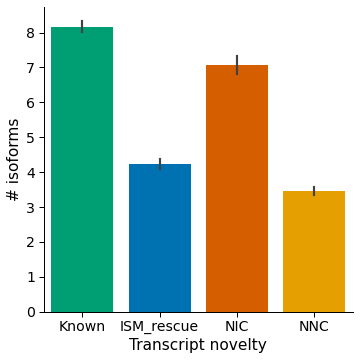

In [33]:
df = pd.read_csv(filt_ab, sep='\t')
min_tpm=1
gene_subset='polya'
nov=complete_novs
opref='figures/human'

df_back = df.copy(deep=True)

# detected isoforms
det_df = get_isos_per_gene(df,
                   min_tpm=min_tpm,
                   gene_subset=gene_subset,
                   groupby='all', 
                   nov=nov)
det_df.rename({'all': 'n_isos_det'}, axis=1, inplace=True)

# annotated isoforms
gc_df = get_n_gencode_isos(subset='polya')
gc_df = gc_df[['gid', 'n_isos_gencode']]

df = det_df.merge(gc_df, how='left', left_index=True, right_on='gid')    

# add gene name 
gene_df, _, _ = get_gtf_info(how='gene', subset='polya')
gene_df = gene_df[['gid', 'gname']]
df = df.merge(gene_df, how='left', on='gid')

df['ratio'] = df['n_isos_det'] / df['n_isos_gencode']
gids = df.loc[df['ratio']>1.5, 'gid'].tolist()
len(df.loc[df['ratio']>1.5])

t_df = df_back.copy(deep=True)
t_df = t_df[['annot_transcript_id', 'transcript_novelty', 'annot_gene_id', 'annot_gene_name']]
df = get_det_table(df_back, 
                   how='iso', 
                   min_tpm=1, 
                   gene_subset='polya',
                   groupby='all',
                   nov=complete_novs)
df = df.transpose()

df = df.merge(t_df, how='left', left_index=True, right_on='annot_transcript_id')
df = df.loc[df.annot_gene_id.isin(gids)]

df.drop('all', axis=1, inplace=True)
df = df.groupby(['annot_gene_id', 'annot_gene_name', 'transcript_novelty'], dropna=False).count().reset_index()
df.rename({'annot_transcript_id': 'n_isos'}, axis=1, inplace=True)
df.head()

# plot the plot
sns.set_context('paper', font_scale=1.6)
plt.figure(figsize=(4,6))

c_dict, order = get_talon_nov_colors(cats=nov)
# ax = sns.boxplot(data=df, x='transcript_novelty', y='n_isos',
#                  order=order, palette=c_dict,
#                  saturation=1)

ax = sns.catplot(data=df, x='transcript_novelty', y='n_isos',
                 order=order, palette=c_dict, kind='bar', saturation=1)


# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

xlabel = 'Transcript novelty'
ylabel = '# isoforms'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)

fname = '{}_isos_per_many_iso_gene.png'.format(opref)
plt.savefig(fname, dpi=300, bbox_inches='tight')

How does the max # isoforms detected per gene / sample compare to the number of isoforms detected per gene overall across the whole dataset?

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164
Found 50 total samples
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164
       max_isos  total_isos                 gid gname  length         biotype  \
21978     281.0         286  ENSG00000049540.16   ELN   42118  protein_coding   

      biotype_category     tf  
21978   protein_coding  False  


,max_isos,total_isos,gid,gname,length,biotype,biotype_category,tf,ratio
20125,23.0,67,ENSG00000029363.16,BCLAF1,33224,protein_coding,protein_coding,False,0.343284
14094,22.0,59,ENSG00000164073.10,MFSD8,48302,protein_coding,protein_coding,False,0.372881
55133,28.0,75,ENSG00000253352.9,TUG1,10150,bidirectional_promoter_lncRNA,lncRNA,False,0.373333
51738,24.0,57,ENSG00000130844.17,ZNF331,60742,protein_coding,protein_coding,True,0.421053
11408,25.0,57,ENSG00000114120.12,SLC25A36,39131,protein_coding,protein_coding,False,0.438596
...,...,...,...,...,...,...,...,...,...
24057,54.0,54,ENSG00000168484.12,SFTPC,7566,protein_coding,protein_coding,False,1.000000
29532,74.0,74,ENSG00000122852.14,SFTPA1,4516,protein_coding,protein_coding,False,1.000000
25834,64.0,64,ENSG00000160882.11,CYP11B1,7490,protein_coding,protein_coding,False,1.000000
6694,163.0,163,ENSG00000168878.16,SFTPB,11427,protein_coding,protein_coding,False,1.000000


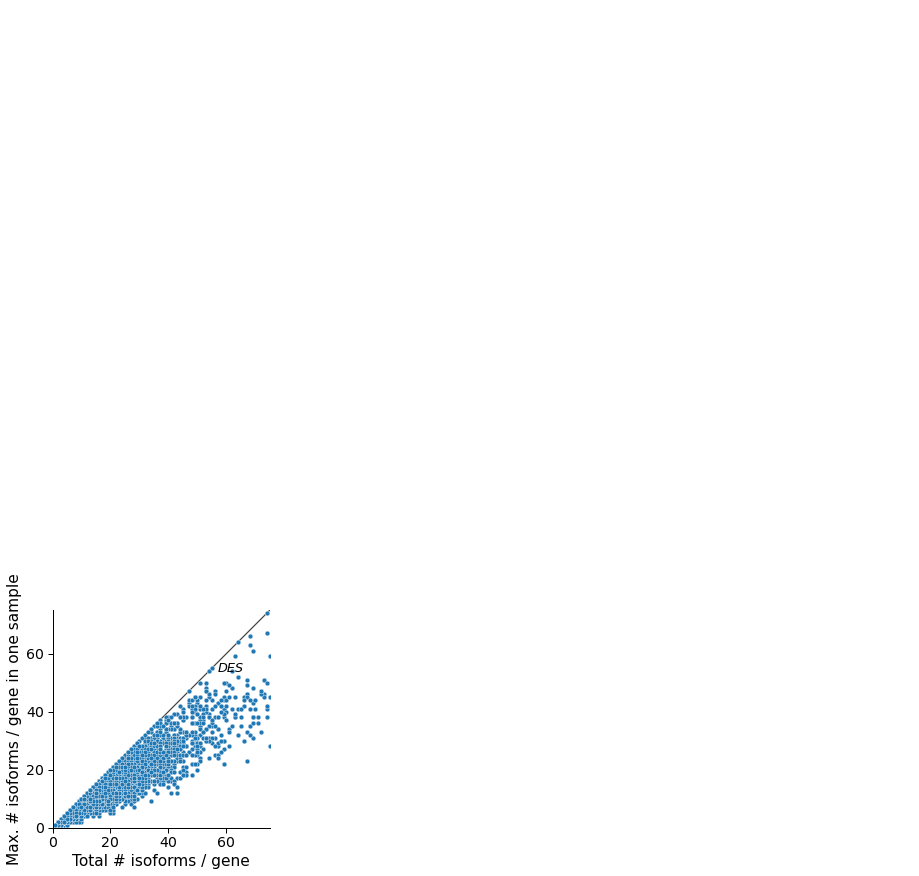

In [35]:
df = pd.read_csv(filt_ab, sep='\t')
df = plot_max_vs_all_isos(df,
                         min_tpm=1,
                         gene_subset='polya',
                         nov=complete_novs,
                         label_genes=['TPM1', 'DES', 'MAPK10', 'FN1', 'SFTPA1', 'ELN'],
                         xlim=75,
                         ylim=75,
                         opref='figures/human')

print(df.loc[df.gname=='ELN'])
df['ratio'] = df['max_isos'] / df['total_isos']
df.loc[df['total_isos'] > 50].sort_values(by='ratio', ascending=True)

What # of genes do we detect >15 isoforms overall that have >15 annotated isoforms in GENCODE?

In [37]:
df = pd.read_csv(filt_ab, sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='all', 
                       nov=complete_novs)
df.head()

df = df.loc[df['all'] > 15]

gene_df, _, _ = get_gtf_info(how='iso', subset='polya', ver=ver)
gene_df = gene_df[['gid', 'tid']]
gene_df = gene_df.groupby('gid').count().reset_index()
gene_df.rename({'tid': 'n_isos_gencode'}, axis=1, inplace=True)
gene_df.sort_values(by='n_isos_gencode', ascending=False, inplace=True)
gene_df = gene_df.loc[gene_df.n_isos_gencode > 15]

# get intersection of genes wih >15 annotated isoforms and 
# genes that we detect >15 isoforms in at least one sample
n = len(set(gene_df.gid.tolist())&set(df.index.tolist()))
total = len(df.index)

print('{} / {} genes w/ >15 isoforms detected overall have >15 isoforms annotated in GENCODE'.format(n, total))

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164
25 / 4337 genes w/ >15 isoforms detected overall have >15 isoforms annotated in GENCODE


Deeper dive into what's going on with _ELN_

In [40]:
temp = df.max(axis=1).to_frame()
n = df.max().max()
temp.loc[temp[0] == 286]

,0
annot_gene_id,
ENSG00000049540.16,286


In [41]:
df.loc['ENSG00000049540.16'].idxmax()

'all'

How many different tissues express Elastin? How many isoforms are detected in these tissues?

In [42]:
df.loc['ENSG00000049540.16']

all    286
Name: ENSG00000049540.16, dtype: int64

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164
Found 50 total samples


<Figure size 288x432 with 0 Axes>

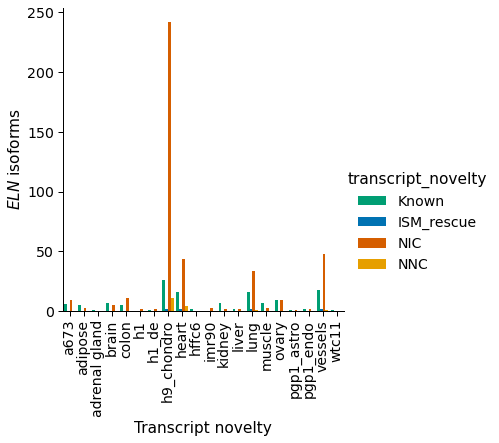

In [43]:
df = pd.read_csv(filt_ab, sep='\t')
plot_transcript_novelty_per(df, 
                            gene='ELN', 
                            min_tpm=1, 
                            gene_subset='polya', 
                            groupby='sample', 
                            nov=complete_novs, 
                            opref='figures/human')

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164
Found 50 total samples


<Figure size 288x432 with 0 Axes>

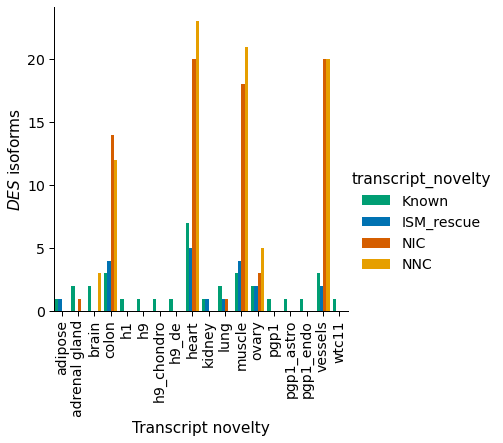

In [44]:
df = pd.read_csv(filt_ab, sep='\t')
plot_transcript_novelty_per(df, 
                            gene='DES', 
                            min_tpm=1, 
                            gene_subset='polya', 
                            groupby='sample', 
                            nov=complete_novs, 
                            opref='figures/human')

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164
Found 50 total samples


<Figure size 288x432 with 0 Axes>

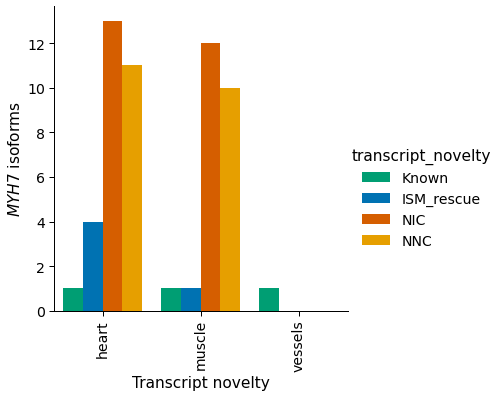

In [45]:
df = pd.read_csv(filt_ab, sep='\t')
plot_transcript_novelty_per(df, 
                            gene='MYH7', 
                            min_tpm=1, 
                            gene_subset='polya', 
                            groupby='sample', 
                            nov=complete_novs, 
                            opref='figures/human')

What novelty type do each of these isoforms have in just h9 chondro?

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164
Found 50 total samples


<Figure size 288x432 with 0 Axes>

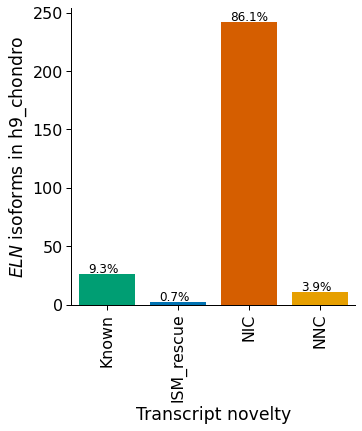

In [46]:
df = pd.read_csv(filt_ab, sep='\t')
plot_transcript_novelty_per_1(df, 
                            dataset='h9_chondro',
                            gene='ELN',
                            min_tpm=1,
                            gene_subset='polya',
                            groupby='sample',
                            nov=complete_novs, 
                            opref='figures/human')

Which samples have the highest average?

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164
Found 50 total samples


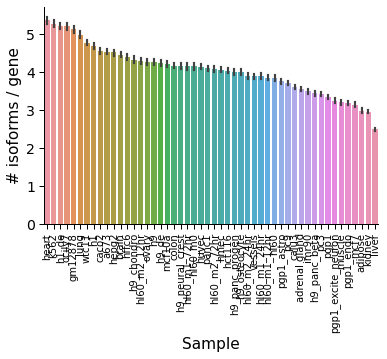

In [47]:
df = pd.read_csv(filt_ab, sep='\t')
plot_avg_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       sample='all', 
                       groupby='sample',
                       nov=complete_novs,
                       opref='figures/human')

Calculating iso TPM values
Subsetting for tissue datasets
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 151334
Applying gene type and novelty subset
Number of isos reported: 149372
Found 11 total samples


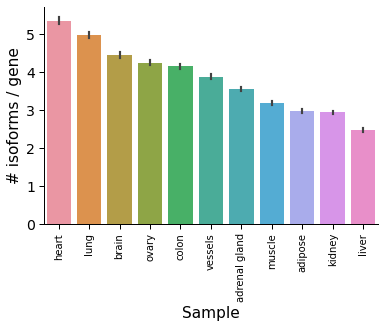

In [48]:
df = pd.read_csv(filt_ab, sep='\t')
plot_avg_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       sample='tissue', 
                       groupby='sample',
                       nov=complete_novs,
                       opref='figures/human')

What's the distribution of number of isoforms detected per gene per sample?

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164
Found 50 total samples


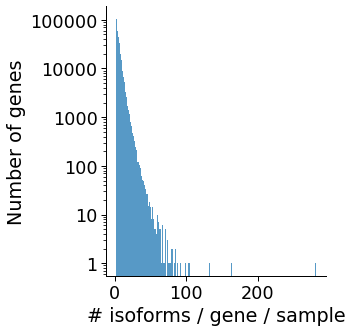

In [49]:
df = pd.read_csv(filt_ab, sep='\t')
df, ax = plot_isos_per_gene_hist(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample', 
                       nov=complete_novs,
                       rm_1=True)

How many genes have >15, >10 isoforms expressed in a sample?

In [50]:
df = pd.read_csv(filt_ab, sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample',
                       nov=complete_novs)

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164
Found 50 total samples


In [51]:
df = df.loc[(df > 10).any(axis=1)]
n = len(df.index)
print('{} genes with >10 complete isoforms / gene in at least one sample'.format(n))

4801 genes with >10 complete isoforms / gene in at least one sample


In [52]:
print(len(df.index))
df.head()

4801


,a673,adipose,adrenal gland,brain,caco2,calu3,colon,gm12878,h1,h1_de,...,ovary,panc1,pc3,pc9,pgp1,pgp1_astro,pgp1_endo,pgp1_excite_neuron,vessels,wtc11
annot_gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.14,11.0,5.0,4.0,7.0,18.0,8.0,16.0,1.0,13.0,14.0,...,10.0,3.0,4.0,7.0,9.0,7.0,8.0,11.0,6.0,15.0
ENSG00000000419.12,8.0,2.0,5.0,8.0,11.0,6.0,6.0,10.0,5.0,4.0,...,5.0,6.0,5.0,7.0,6.0,8.0,5.0,6.0,8.0,5.0
ENSG00000000938.12,NaN,6.0,1.0,5.0,NaN,NaN,2.0,9.0,1.0,NaN,...,2.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,6.0,NaN
ENSG00000001036.13,5.0,4.0,7.0,9.0,11.0,7.0,10.0,8.0,10.0,10.0,...,9.0,7.0,5.0,9.0,5.0,3.0,4.0,4.0,9.0,7.0
ENSG00000001084.12,1.0,1.0,2.0,3.0,5.0,3.0,2.0,2.0,7.0,11.0,...,2.0,2.0,8.0,6.0,1.0,2.0,NaN,2.0,3.0,7.0


In [54]:
# enrichr on these genes
dbs = ['GO_Biological_Process_2021',
       'GO_Cellular_Component_2021',
       'GO_Molecular_Function_2021',
       'KEGG_2021_Human']
bm = gp.parser.Biomart()
datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
datasets.loc[datasets.Description.str.contains('Human')]

df['gid'] = df.index
# gids = df.gid.str.rsplit('.', n=1, expand=True)[0].to_frame()
gids = df.gid.tolist()
df.drop('gid', axis=1, inplace=True)
gids = gids.squeeze().str.strip().tolist()
gids = bm.query(dataset='hsapiens_gene_ensembl',
           attributes=['ensembl_gene_id', 'external_gene_name'],
           filters={'ensembl_gene_id': gids})
gids = gids.loc[~gids.external_gene_name.isna()]
gnames = gids.external_gene_name.squeeze().str.strip().tolist()
go = gp.enrichr(gene_list=gnames,
                gene_sets=dbs,
                organism='Human',
                description='highly_spliced_isos',
                outdir='highly_spliced_isos_GO',
                cutoff=0.5)

AttributeError: 'list' object has no attribute 'squeeze'

In [ ]:
df = df.loc[(df > 15).any(axis=1)]
n = len(df.index)
print('{} genes with >15 complete isoforms / gene in at least one sample'.format(n))

In [ ]:
# enrichr on these genes
dbs = ['GO_Biological_Process_2021',
       'GO_Cellular_Component_2021',
       'GO_Molecular_Function_2021',
       'KEGG_2021_Human']
bm = gp.parser.Biomart()
datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
datasets.loc[datasets.Description.str.contains('Human')]

df['gid'] = df.index
# gids = df.gid.str.rsplit('.', n=1, expand=True)[0].to_frame()
df.drop('gid', axis=1, inplace=True)
gids = gids.squeeze().str.strip().tolist()
gids = bm.query(dataset='hsapiens_gene_ensembl',
           attributes=['ensembl_gene_id', 'external_gene_name'],
           filters={'ensembl_gene_id': gids})
gids = gids.loc[~gids.external_gene_name.isna()]
gnames = gids.external_gene_name.squeeze().str.strip().tolist()
go = gp.enrichr(gene_list=gnames,
                gene_sets=dbs,
                organism='Human',
                description='highly_spliced_isos_15',
                outdir='highly_spliced_isos_15_GO',
                cutoff=0.5)

What are the identities of highly-spliced genes?

In [56]:
df = pd.read_csv(filt_ab, sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample',
                       nov=complete_novs)

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164
Found 50 total samples


In [57]:
df['max_isos_sample'] = df.max(axis=1)
df['max_sample'] = df.idxmax(axis=1)
df = df[['max_isos_sample', 'max_sample']]
df = df.sort_values('max_isos_sample', ascending=False)

In [58]:
g_df = pd.read_csv(filt_ab, sep='\t')
g_df = g_df[['annot_gene_name', 'annot_gene_id']].drop_duplicates()
df = df.merge(g_df, how='left', left_index=True, right_on='annot_gene_id')

In [59]:
print('Top 10 genes with isoforms / gene / sample')
df.head(10)

Top 10 genes with isoforms / gene / sample


,max_isos_sample,max_sample,annot_gene_name,annot_gene_id
93401,281.0,h9_chondro,ELN,ENSG00000049540.16
29931,163.0,lung,SFTPB,ENSG00000168878.16
70848,132.0,heart,PAM,ENSG00000145730.20
38043,104.0,h9_chondro,FN1,ENSG00000115414.18
101060,103.0,lung,CTSB,ENSG00000164733.20
70597,92.0,heart,CAST,ENSG00000153113.23
176506,87.0,hl60_m0,LINC02244,ENSG00000259590.1
107019,84.0,hl60_m0,DCSTAMP,ENSG00000164935.6
112962,81.0,h1_de,HNRNPK,ENSG00000165119.20
44805,80.0,heart,MAP4,ENSG00000047849.21


In [60]:
# save table 
df.to_csv('isos_per_gene_per_sample_min_15.tsv', sep='\t')

Number of libraries per sample

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164
Found 50 total samples
Slope of correlation: 0.1350652853027843
R of correlation: 0.5330590720079246
R2 of correlation: 0.6499835126474629


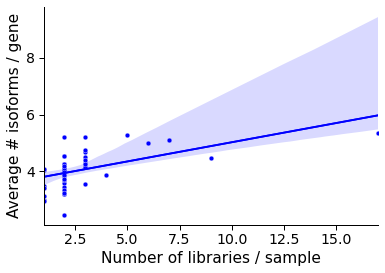

In [61]:
df = pd.read_csv(filt_ab, sep='\t')
plot_n_libs_v_avg_isos(df,
                        min_tpm=1,
                        gene_subset='polya',
                        sample='all',
                        nov=complete_novs, 
                        opref='figures/human')

Number of reads per sample

/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1032: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.sum(axis=1).to_frame()


Found 50 total samples
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164
Found 50 total samples
Slope of correlation: 9.456099940513355e-08
R of correlation: 0.5573411363394731
R2 of correlation: 0.6499399759903962


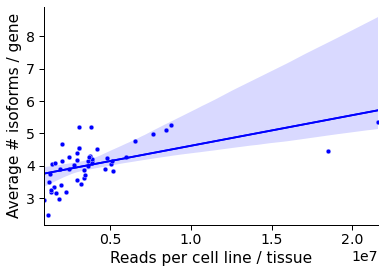

In [62]:
df = pd.read_csv(ab, sep='\t')
filt_df = pd.read_csv(filt_ab, sep='\t')
plot_n_reads_v_avg_isos(df, filt_df,
                        min_tpm=1,
                        gene_subset='polya',
                        sample='all',
                        groupby='sample',
                        nov=complete_novs, 
                        opref='figures/human')

What fraction of polyA genes express >= 2 complete isoforms in more than half of their expressed samples?

/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1032: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.sum(axis=1).to_frame()


Found 50 total samples
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]


Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164
Found 50 total samples
Slope of correlation: 9.456099940513355e-08
R of correlation: 0.5573411363394731
R2 of correlation: 0.6499399759903962


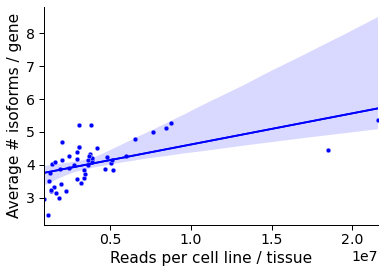

In [63]:
df = pd.read_csv(ab, sep='\t')
filt_df = pd.read_csv(filt_ab, sep='\t')
plot_n_reads_v_avg_isos(df, filt_df,
                        min_tpm=1,
                        gene_subset='polya',
                        sample='all',
                        groupby='sample',
                        nov=complete_novs, 
                        opref='figures/human')

What fraction of polyA genes express >= 2 complete isoforms in more than half of their expressed samples?

In [65]:
filt_df = pd.read_csv(filt_ab, sep='\t')
df = pd.read_csv(ab, sep='\t')

df = get_gene_iso_det_table(df, filt_df,
                            min_isos=2,
                            iso_nov=complete_novs,
                            gene_nov=['Known'],
                            gene_subset='polya',
                            min_tpm=1,
                            sample='all',
                            groupby='sample')

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # genes detected: 599976
# genes >= 1 tpm: 292060
Applying gene type and novelty subset
Number of genes reported: 34027
Found 50 total samples
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164
Found 50 total samples


In [66]:
df = df.apply(pd.Series.value_counts)
df = df.transpose()
df.fillna(0, inplace=True)
df.rename({'00': 'no_det',
             '01': 'gene_det',
             '10': 'iso_det',
             '11': 'gene_iso_det'}, axis=1, inplace=True)

df['total_gene_det'] = df['gene_det']+df['gene_iso_det']
df['prop'] = df['gene_iso_det']/df['total_gene_det']

n_gene_iso = len(df.loc[df.prop >= .5])
n = len(df.index)

print('{} / {} ({:.2f}%) detected polyA genes express >=2 isoforms in at least half of their expressed samples'.format(n_gene_iso, n, (n_gene_iso/n)*100))

10314 / 34027 (30.31%) detected polyA genes express >=2 isoforms in at least half of their expressed samples


What fraction of TF genes express >= 2 complete isoforms in more than half of their expressed samples?


In [67]:
filt_df = pd.read_csv(ab, sep='\t')
df = pd.read_csv(filt_ab, sep='\t')

df = get_gene_iso_det_table(df, filt_df,
                            min_isos=2,
                            iso_nov=complete_novs,
                            gene_nov=['Known'],
                            gene_subset='tf',
                            min_tpm=1,
                            sample='all',
                            groupby='sample')

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for tf genes
Enforcing minimum TPM
Total # genes detected: 34673
# genes >= 1 tpm: 30075
Applying gene type and novelty subset
Number of genes reported: 1333
Found 50 total samples
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for tf genes
Enforcing minimum TPM
Total # isos detected: 5401754
# isos >= 1 tpm: 1669566
Applying gene type and novelty subset
Number of isos reported: 30119
Found 50 total samples


In [68]:
df = df.apply(pd.Series.value_counts)
df = df.transpose()
df.fillna(0, inplace=True)
df.rename({'00': 'no_det',
             '01': 'gene_det',
             '10': 'iso_det',
             '11': 'gene_iso_det'}, axis=1, inplace=True)

df['total_gene_det'] = df['gene_det']+df['gene_iso_det']
df['prop'] = df['gene_iso_det']/df['total_gene_det']

n_gene_iso = len(df.loc[df.prop >= .5])
n = len(df.index)

print('{} / {} ({:.2f}%) detected TF genes express >=2 isoforms in at least half of their expressed samples'.format(n_gene_iso, n, (n_gene_iso/n)*100))

759 / 1333 (56.94%) detected TF genes express >=2 isoforms in at least half of their expressed samples


What fraction of polyA genes have >= 2 complete isoforms detected in the same sample?

In [70]:
df = pd.read_csv(filt_ab, sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample', 
                       nov=complete_novs)

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 219164
Found 50 total samples


In [71]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene', subset='polya', ver=ver)
n_polya = len(gene_df.index)

df = df.loc[(df > 2).any(axis=1)]
n_det_polya = len(df.index)

print('{} / {} ({:.2f}%) annotated polyA genes have >= 2 isoforms expressed in >= 1 sample'.format(n_det_polya, n_polya, (n_det_polya/n_polya)*100))

15168 / 52274 (29.02%) annotated polyA genes have >= 2 isoforms expressed in >= 1 sample


What fraction of TF genes have >= 2 complete isoforms detected in the same sample?

In [72]:
df = pd.read_csv(filt_ab, sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='tf',
                       groupby='sample', 
                       nov=complete_novs)

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC', 'ISM_rescue']
Subsetting for tf genes
Enforcing minimum TPM
Total # isos detected: 245379
# isos >= 1 tpm: 223477
Applying gene type and novelty subset
Number of isos reported: 13122
Found 50 total samples


In [73]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene', subset='tf', ver=ver)
n_polya = len(gene_df.index)

df = df.loc[(df > 2).any(axis=1)]
n_det_polya = len(df.index)

print('{} / {} ({:.2f}%) annotated TF genes have >= 2 isoforms expressed in >= 1 sample'.format(n_det_polya, n_polya, (n_det_polya/n_polya)*100))

1033 / 1419 (72.80%) annotated TF genes have >= 2 isoforms expressed in >= 1 sample
